In [2]:
import numpy as np
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection
import utilis

import keras_ocr

tf.compat.v1.disable_eager_execution()
tf.compat.v1.experimental.output_all_intermediates(True)

# tf.config.list_physical_devices('GPU')

# assert tf.test.is_gpu_available()

In [3]:
dataset_labels = utilis.get_labels_dataset()[:-50]
print("Dataset len:", len(dataset_labels))
dataset_labels[:2]

Dataset len: 1000


[('image_dataset/img_842.png', None, 'di'),
 ('image_dataset/img_2401.png', None, 'particolari')]

In [4]:
test_labels = utilis.get_labels_dataset()[1000:]
print("Test len:", len(test_labels))

Test len: 50


In [5]:
recognizer = keras_ocr.recognition.Recognizer()
recognizer.compile()
recognizer_alphabet = recognizer.alphabet +'/'
recognizer_alphabet

Instructions for updating:
Colocations handled automatically by placer.


2024-02-20 17:01:25.838921: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2024-02-20 17:01:25.894021: W tensorflow/c/c_api.cc:305] Operation '{name:'bn_5/moving_mean/Assign' id:192 op device:{requested: '', assigned: ''} def:{{{node bn_5/moving_mean/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bn_5/moving_mean, bn_5/moving_mean/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Looking for /Users/gmarini/.keras-ocr/crnn_kurapan.h5


2024-02-20 17:01:26.466633: W tensorflow/c/c_api.cc:305] Operation '{name:'fc_12/bias/Assign' id:1876 op device:{requested: '', assigned: ''} def:{{{node fc_12/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](fc_12/bias, fc_12/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


'0123456789abcdefghijklmnopqrstuvwxyz/'

In [6]:
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

train_labels, validation_labels = sklearn.model_selection.train_test_split(dataset_labels, test_size=0.2, random_state=42)

print("Train len:", len(train_labels))
print("Train example:", train_labels[:2])
print("Validation len", len(validation_labels))


Train len: 800
Train example: [('image_dataset/img_301.png', None, '22i05i1966'), ('image_dataset/img_1865.png', None, 'nascita')]
Validation len 200


In [7]:
batch_size = 8

(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]     
]

In [8]:
print(training_image_gen, training_steps)
print(validation_image_gen, validation_steps)

<generator object get_recognizer_image_generator at 0x2a11bb1b0> 100
<generator object get_recognizer_image_generator at 0x2a11fe8f0> 25


In [9]:
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

51 / 800 instances have illegal characters.
text: repubblica


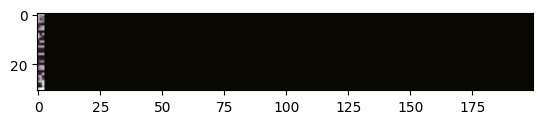

In [10]:
image, text = next(training_image_gen)
print('text:', text)
_ = plt.imshow(image)

10 / 200 instances have illegal characters.
text: iidentity


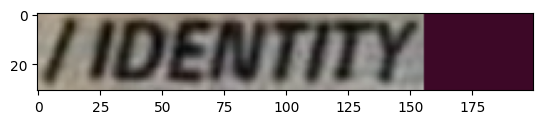

In [11]:
image, text = next(validation_image_gen)
print('text:', text)
_ = plt.imshow(image)

In [12]:
# RECOGNIZER LOAD_MODEL / FIT
recognizer.model = tf.keras.models.load_model('modelli_allenati/recogn_model_colab_05')

# callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
#     tf.keras.callbacks.ModelCheckpoint('recognizer_borndigital.h5', monitor='val_loss', save_best_only=True),
#     tf.keras.callbacks.CSVLogger('recognizer_borndigital.csv')
# ]
# recognizer.training_model.fit(
#     training_gen,
#     steps_per_epoch=training_steps,
#     # validation_steps=validation_steps,
#     validation_steps=3,
#     validation_data=validation_gen,
#     callbacks=callbacks,
#     epochs=10,
# )

2024-02-20 17:01:29.210579: W tensorflow/c/c_api.cc:305] Operation '{name:'AssignVariableOp_81' id:2912 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_81}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](bias_10, Identity_33)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Predicted: cunascita, Actual: di nascita


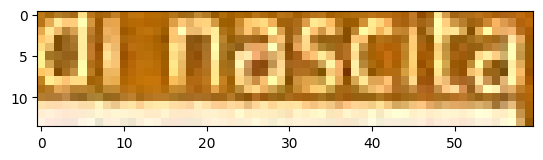

In [22]:
image_filepath, _, actual = test_labels[np.random.randint(0,  len(test_labels))]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

In [14]:
# SAVE MODEL
# recognizer.model.save('modelli_allenati/recognizer_model')